In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

#from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

#from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPoint
#from src.weight_init import keras_init
#rom src.losses import categorical_crossentropy_2d
#rom src.models import SpliceAI_10K
#from src.evaluation_metrics import print_topl_statistics
import copy
#import tensorflow as tf

In [2]:
!nvidia-smi

Tue May 21 12:17:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:01:00.0 Off |                  N/A |
| 32%   40C    P0             59W /  320W |       0MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
rng = np.random.default_rng(23673)

In [4]:
data_dir = '../Data'

In [5]:
#setType = 'all'
#annotation, transcriptToLabel, seqData = getData(data_dir, setType)

In [6]:
#gtf = None

In [7]:
L = 32
N_GPUS = 4
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

In [8]:
SL=5000
CL_max=10000

In [9]:
def parse_gtf(gtf_file):
    """Parse GTF file and return a DataFrame."""
    columns = [
        'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'
    ]
    df = pd.read_csv(gtf_file, sep='\t', comment='#', names=columns)
    
    # Filter for genes only
    df = df[df['feature'] == 'gene']
    
    # Parse attributes to get gene_id and gene_name
    df['gene_id'] = df['attribute'].str.extract('gene_id "([^"]+)"')
    df['gene_name'] = df['attribute'].str.extract('gene_name "([^"]+)"')
    
    return df[['gene_id', 'gene_name', 'seqname', 'start', 'end', 'strand']]

def get_gene_info(gene_names, gtf_file):
    """Return gene information for a list of gene names."""
    gtf_data = parse_gtf(gtf_file)
    
    # Filter for the genes of interest
    gene_info = gtf_data[gtf_data['gene_name'].isin(gene_names)]
    
    return gene_info

In [10]:
import pyfastx
data_dir = '../Data/'
fasta_file_path = '../Data/genome.fa'
gtf_file_path = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX/gencode.v26.annotation.gtf'
fasta = pyfastx.Fasta(fasta_file_path)

In [11]:
clinvar = pd.read_csv('/odinn/tmp/benediktj/Data/ClinVar/clinvar_splice_variants.tsv',sep='\t')
gene_names = clinvar.gene_info.apply(lambda x: x.split(':')[0]).unique()
gene_info = get_gene_info(gene_names, gtf_file_path)
clinvar['gene_name'] = clinvar.gene_info.apply(lambda x: x.split(':')[0])
gene_info = gene_info.drop_duplicates('gene_name')
clinvar = clinvar.merge(gene_info,on='gene_name',how='left')
clinvar = clinvar[clinvar['chromosome'].isin([str(x) for x in list(range(1,23))])]
clinvar = clinvar.dropna()

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D, Cropping1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import add
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Lambda

def ResidualUnit(l, w, ar):
    # Residual unit proposed in "Identity mappings in Deep Residual Networks"
    # by He et al.

    def f(input_node):

        bn1 = BatchNormalization()(input_node)
        act1 = Activation('relu')(bn1)
        conv1 = Conv1D(l, [w], dilation_rate=[ar], padding='same')(act1)
        bn2 = BatchNormalization()(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv1D(l, [w], dilation_rate=[ar], padding='same')(act2)
        output_node = add([conv2, input_node])

        return output_node

    return f


def SpliceAI(L, W, AR):
    # L: Number of convolution kernels
    # W: Convolution window size in each residual unit
    # AR: Atrous rate in each residual unit

    assert len(W) == len(AR)

    CL = 2 * np.sum(AR*(W-1))

    input0 = Input(shape=(None, 4))
    conv = Conv1D(L, 1)(input0)
    skip = Conv1D(L, 1)(conv)

    for i in range(len(W)):
        conv = ResidualUnit(L, W[i], AR[i])(conv)
        
        if (((i+1) % 4 == 0) or ((i+1) == len(W))):
            # Skip connections to the output after every 4 residual units
            dense = Conv1D(L, 1)(conv)
            skip = add([skip, dense])

    skip = Cropping1D(int(CL/2))(skip)

    output0 = [[] for t in range(1)]

    for t in range(1):
        output0[t] = Conv1D(3, 1, activation='softmax')(skip)
    
    model = Model(inputs=input0, outputs=output0)

    return model


def categorical_crossentropy_2d(y_true, y_pred):
    # Standard categorical cross entropy for sequence outputs
    weights = [3.33445928e-01, 1.97431150e+03, 1.97432843e+03]
    return - kb.mean(weights[0]*y_true[:, :, 0]*kb.log(y_pred[:, :, 0]+1e-10)
                   + weights[1]*y_true[:, :, 1]*kb.log(y_pred[:, :, 1]+1e-10)
                   + weights[2]*y_true[:, :, 2]*kb.log(y_pred[:, :, 2]+1e-10))


2024-05-21 12:17:25.931549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [13]:
from pkg_resources import resource_filename
from tensorflow.keras.models import load_model 

models = []
n_models = 5

paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
models = [load_model(resource_filename('spliceai', x)) for x in paths]

device = torch.device("cpu")

2024-05-21 12:17:28.481802: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-21 12:17:30.019233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-21 12:17:30.020711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3080 major: 8 minor: 6 memoryClockRate(GHz): 1.74
pciBusID: 0000:01:00.0
2024-05-21 12:17:30.020817: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-05-21 12:17:30.024907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-05-21 12:17:30.026578: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libc

In [14]:
def predictSplicing(seq,models):
    outputs = []
    for i in range(seq.shape[0]):
        Xc = torch.tensor(seq[i,:,:], device=device).float().unsqueeze(0).numpy()
        #Xc = torch.swapaxes(batch_features,1,2)
        predictions = []
        for v in range(n_models):
            Yp = models[v].predict(Xc, batch_size=1)
            predictions.append(Yp)
        predictions = (predictions[0]+predictions[1]+predictions[2]+predictions[3]+predictions[4])/n_models
        outputs.append(np.swapaxes(predictions,1,2))
    
    outputs = np.concatenate(outputs,axis=2)
    #outputs = outputs.cpu().detach().numpy()
    return outputs

def plotPrediction(outputs):
    plt.rcParams.update({'font.size': 18})
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(22, 6),sharex=True)
    x = np.arange(outputs.shape[2])
    ax1.plot(x,outputs[0,1,:],linewidth=2,zorder=-32)
    ax2.plot(x,outputs[0,2,:],linewidth=2,zorder=-32)
    plt.xlabel('Distance from transcript start (nt)')
    ax1.set_ylabel('Acceptor score')
    ax2.set_ylabel('Donor Score')
    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

def ceil_div(x, y):

    return int(ceil(float(x)/y))


IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def one_hot_encode(Xd):

    return IN_MAP[Xd.astype('int8')]

def reformat_data(X0):
    # This function converts X0, Y0 of the create_datapoints function into
    # blocks such that the data is broken down into data points where the
    # input is a sequence of length SL+CL_max corresponding to SL nucleotides
    # of interest and CL_max context nucleotides, the output is a sequence of
    # length SL corresponding to the splicing information of the nucleotides
    # of interest. The CL_max context nucleotides are such that they are
    # CL_max/2 on either side of the SL nucleotides of interest.

    num_points = ceil_div(len(X0)-CL_max, SL)
    Xd = np.zeros((num_points, SL+CL_max))
    X0 = np.pad(X0, [0, SL], 'constant', constant_values=0)

    for i in range(num_points):
        Xd[i] = X0[SL*i:CL_max+SL*(i+1)]

    return Xd

def seqToArray(seq,strand):
    seq = 'N'*(CL_max//2) + seq + 'N'*(CL_max//2)
    seq = seq.upper()
    seq = re.sub(r'[^AGTC]', '0',seq)
    seq = seq.replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    if strand == '+':
        X0 = np.asarray([int(x) for x in seq])
            
    elif strand == '-':
        X0 = (5-np.asarray([int(x) for x in seq[::-1]])) % 5  # Reverse complement
        
    Xd = reformat_data(X0)
    return  one_hot_encode(Xd)
    

def calculate_chromosome_lengths(fasta_file):
    """
    Calculate lengths of chromosomes from a FASTA file.

    Parameters:
    fasta_file (str): Path to the FASTA file.

    Returns:
    dict: A dictionary with chromosome names as keys and their lengths as values.
    """
    chromosome_lengths = {}
    
    fasta = pyfastx.Fasta(fasta_file)
    
    for seq in fasta:
        chromosome_lengths[seq.name] = len(seq)
    
    return chromosome_lengths



In [15]:
chromosome_lengths = calculate_chromosome_lengths(fasta_file_path)
print(chromosome_lengths)

{'chr1': 248956422, 'chr10': 133797422, 'chr11': 135086622, 'chr11_KI270721v1_random': 100316, 'chr12': 133275309, 'chr13': 114364328, 'chr14': 107043718, 'chr14_GL000009v2_random': 201709, 'chr14_GL000194v1_random': 191469, 'chr14_GL000225v1_random': 211173, 'chr14_KI270722v1_random': 194050, 'chr14_KI270723v1_random': 38115, 'chr14_KI270724v1_random': 39555, 'chr14_KI270725v1_random': 172810, 'chr14_KI270726v1_random': 43739, 'chr15': 101991189, 'chr15_KI270727v1_random': 448248, 'chr16': 90338345, 'chr16_KI270728v1_random': 1872759, 'chr17': 83257441, 'chr17_GL000205v2_random': 185591, 'chr17_KI270729v1_random': 280839, 'chr17_KI270730v1_random': 112551, 'chr18': 80373285, 'chr19': 58617616, 'chr1_KI270706v1_random': 175055, 'chr1_KI270707v1_random': 32032, 'chr1_KI270708v1_random': 127682, 'chr1_KI270709v1_random': 66860, 'chr1_KI270710v1_random': 40176, 'chr1_KI270711v1_random': 42210, 'chr1_KI270712v1_random': 176043, 'chr1_KI270713v1_random': 40745, 'chr1_KI270714v1_random': 417

In [16]:
results = {}

for i in tqdm(range(clinvar.shape[0])):
    gene,chrm,strand,pos,gene_start,gene_end,ref_s,alt_s, = clinvar.iloc[i,:][['gene_name','seqname','strand','position','start','end','ref','alt']]
    event_id = i
    names = gene.split(',')
    #gene_start,gene_end = unionBoundry(names,gene_boundries)
    #starts,ends = [],[]
    #if pos<jn_start:
    start,end = np.max([pos-CL_max//2-SL//2,1]),np.min([pos+CL_max//2+SL//2,chromosome_lengths[chrm]])
    #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
    #elif jn_start<=pos<jn_end:
    #    start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
    #else:
    #    start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
    if start < 1:
        start = 1
    #for name in names:
    #    tmp = gene_boundries[name]
    #    starts.append(tmp[0])
    #    ends.append(tmp[1])

    #gene_start,gene_end = np.min(starts),np.max(ends)

     #= df_gene[].iloc[0]
    #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])

    #if strand=='-':
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos+df_gene['acceptor'].iloc[i]-CL_max//2)
    #        ends.append(pos+df_gene['donor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])
    #else:
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos-df_gene['donor'].iloc[i]-CL_max//2)
    #        ends.append(pos-df_gene['acceptor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])

    
    try:
        pos_s = pos-start
        ref = fasta[chrm][start-1:end].seq
        alt = ref
        ref_len = len(ref_s)
        alt_len = len(alt_s)

        assert ref_s == ref[pos_s:(pos_s+ref_len)]

        alt = alt[:pos_s]+alt_s+alt[(pos_s+ref_len):]
        alt_align = np.arange(len(ref))
        alt_align = np.concatenate([alt_align[:pos_s],np.repeat(pos_s,alt_len),alt_align[pos_s+ref_len:]])

        ref_len2 = len(ref)
        alt_len2 = len(alt)

        ref = seqToArray(ref,strand)
        alt = seqToArray(alt,strand)

        ref_prediction = predictSplicing(ref,models)[0,:,:ref_len2]
        alt_prediction = predictSplicing(alt,models)[0,:,:alt_len2]

        tmp = np.zeros_like(ref_prediction)
        if strand=='-':
            ref_prediction = ref_prediction[:,::-1]
            alt_prediction = alt_prediction[:,::-1]

        ref_acceptor = ref_prediction[1,:]
        alt_acceptor = alt_prediction[1,:]
        ref_donor = ref_prediction[2,:]
        alt_donor = alt_prediction[2,:]

        delta_1_a = alt_acceptor[:pos_s]-ref_acceptor[:pos_s]
        delta_1_d = alt_donor[:pos_s]-ref_donor[:pos_s]
        delta_3_a = alt_acceptor[pos_s+alt_len:]-ref_acceptor[pos_s+ref_len:]
        delta_3_d = alt_donor[pos_s+alt_len:]-ref_donor[pos_s+ref_len:]


        if ref_len2==alt_len2:
            delta_2_a = alt_acceptor[pos_s:pos_s+ref_len]-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = alt_donor[pos_s:pos_s+ref_len]-ref_donor[pos_s:pos_s+ref_len]
        elif ref_len2>alt_len2:
            a_pad = np.pad(alt_acceptor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            d_pad = np.pad(alt_donor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            delta_2_a = a_pad-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = d_pad-ref_donor[pos_s:pos_s+ref_len]

        elif ref_len2<alt_len2:
            a_pad = np.pad(ref_acceptor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            d_pad = np.pad(ref_donor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            delta_2_a = alt_acceptor[pos_s:pos_s+alt_len]-a_pad
            delta_2_d = alt_donor[pos_s:pos_s+alt_len]-d_pad

            delta_2_a =np.append(delta_2_a[:ref_len-1],delta_2_a[np.argmax(np.absolute(delta_2_a[ref_len-1:alt_len]))])
            delta_2_d =np.append(delta_2_d[:ref_len-1],delta_2_d[np.argmax(np.absolute(delta_2_d[ref_len-1:alt_len]))])

        acceptorDelta = np.concatenate([delta_1_a,delta_2_a,delta_3_a])
        donorDelta = np.concatenate([delta_1_d,delta_2_d,delta_3_d])

        #acceptor_delta_nr = alt_acceptor.shape[0]-np.argsort(np.argsort(np.absolute(acceptorDelta)))[acceptor_loc]
        #donor_delta_nr = alt_donor.shape[0]-np.argsort(np.argsort(np.absolute(donorDelta)))[donor_loc]
        top_a_creation_pos = np.argmax(acceptorDelta)
        top_d_creation_pos = np.argmax(donorDelta)
        top_a_disruption_pos = np.argmin(acceptorDelta)
        top_d_disruption_pos = np.argmin(donorDelta)
        top_a_creation_delta = acceptorDelta[top_a_creation_pos]
        top_d_creation_delta = donorDelta[top_d_creation_pos]
        top_a_disruption_delta = acceptorDelta[top_a_disruption_pos]
        top_d_disruption_delta = donorDelta[top_d_disruption_pos]

        results[event_id] = [start+top_a_creation_pos,start+top_d_creation_pos,start+top_a_disruption_pos,start+top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,-top_a_disruption_delta,-top_d_disruption_delta]
    except:
        results[event_id] = [float("nan")]*8
        print('{} failed'.format(event_id))

  0%|                                                                                                                                                                                                                                                           | 0/46073 [00:00<?, ?it/s]2024-05-21 12:17:45.825004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-05-21 12:17:47.025678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
  1%|██                                                                                                                                                                                                                                             | 390/46073 [02:19<4:12:04,  3.02it/s]

390 failed


  3%|██████▏                                                                                                                                                                                                                                       | 1201/46073 [06:51<4:14:01,  2.94it/s]

1201 failed


  3%|███████▍                                                                                                                                                                                                                                      | 1432/46073 [08:09<4:06:53,  3.01it/s]

1432 failed


  7%|████████████████▊                                                                                                                                                                                                                             | 3243/46073 [18:12<3:53:37,  3.06it/s]

3243 failed


 10%|██████████████████████▊                                                                                                                                                                                                                       | 4419/46073 [24:36<3:47:43,  3.05it/s]

4419 failed


 10%|██████████████████████▊                                                                                                                                                                                                                       | 4422/46073 [24:37<3:05:29,  3.74it/s]

4422 failed


 10%|██████████████████████▉                                                                                                                                                                                                                       | 4443/46073 [24:43<3:31:30,  3.28it/s]

4443 failed
4444 failed


 10%|████████████████████████▏                                                                                                                                                                                                                     | 4678/46073 [25:59<3:46:11,  3.05it/s]

4678 failed


 11%|█████████████████████████▍                                                                                                                                                                                                                    | 4926/46073 [27:17<3:45:12,  3.05it/s]

4926 failed


 15%|██████████████████████████████████▌                                                                                                                                                                                                           | 6681/46073 [36:52<3:29:11,  3.14it/s]

6681 failed


 17%|█████████████████████████████████████████                                                                                                                                                                                                     | 7948/46073 [43:45<3:23:28,  3.12it/s]

7948 failed


 17%|█████████████████████████████████████████                                                                                                                                                                                                     | 7957/46073 [43:48<3:24:02,  3.11it/s]

7957 failed


 17%|█████████████████████████████████████████▏                                                                                                                                                                                                    | 7976/46073 [43:54<3:28:33,  3.04it/s]

7976 failed


 17%|█████████████████████████████████████████▏                                                                                                                                                                                                    | 7978/46073 [43:54<2:41:22,  3.93it/s]

7978 failed


 19%|████████████████████████████████████████████▍                                                                                                                                                                                                 | 8601/46073 [47:18<3:21:58,  3.09it/s]

8601 failed


 19%|█████████████████████████████████████████████▏                                                                                                                                                                                                | 8751/46073 [48:07<3:23:15,  3.06it/s]

8751 failed


 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 9199/46073 [50:32<3:14:37,  3.16it/s]

9199 failed


 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 9205/46073 [50:33<2:47:38,  3.67it/s]

9205 failed
9206 failed


 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 9208/46073 [50:33<1:49:27,  5.61it/s]

9208 failed


 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                            | 9531/46073 [52:18<3:09:38,  3.21it/s]

9531 failed


 21%|█████████████████████████████████████████████████▌                                                                                                                                                                                            | 9586/46073 [52:35<3:12:50,  3.15it/s]

9586 failed


 22%|███████████████████████████████████████████████████▍                                                                                                                                                                                         | 10003/46073 [54:49<3:14:11,  3.10it/s]

10003 failed


 25%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                | 11462/46073 [1:02:45<3:12:43,  2.99it/s]

11462 failed


 27%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 12327/46073 [1:07:25<3:01:17,  3.10it/s]

12327 failed


 30%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 13734/46073 [1:15:01<2:53:14,  3.11it/s]

13734 failed


 30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 13824/46073 [1:15:30<2:58:22,  3.01it/s]

13824 failed


 31%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 14182/46073 [1:17:25<2:41:25,  3.29it/s]

14182 failed


 31%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 14466/46073 [1:18:56<2:55:35,  3.00it/s]

14466 failed


 33%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 15161/46073 [1:22:42<2:51:52,  3.00it/s]

15161 failed


 37%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 17239/46073 [1:33:54<2:42:09,  2.96it/s]

17239 failed


 37%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 17258/46073 [1:34:00<2:41:23,  2.98it/s]

17258 failed


 38%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 17286/46073 [1:34:09<2:37:16,  3.05it/s]

17286 failed


 38%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 17342/46073 [1:34:26<2:41:23,  2.97it/s]

17342 failed


 41%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 18759/46073 [1:42:06<2:30:56,  3.02it/s]

18759 failed


 41%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 18870/46073 [1:42:41<2:22:12,  3.19it/s]

18870 failed


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 19217/46073 [1:44:32<2:27:51,  3.03it/s]

19217 failed


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 19519/46073 [1:46:09<2:22:03,  3.12it/s]

19519 failed


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 19682/46073 [1:47:01<2:23:25,  3.07it/s]

19682 failed


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 20182/46073 [1:49:45<2:23:40,  3.00it/s]

20182 failed


 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 20219/46073 [1:49:57<2:18:52,  3.10it/s]

20219 failed


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 20507/46073 [1:51:30<2:19:34,  3.05it/s]

20507 failed


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 21621/46073 [1:57:31<2:12:48,  3.07it/s]

21621 failed


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 21793/46073 [1:58:27<2:10:48,  3.09it/s]

21793 failed


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 23029/46073 [2:05:07<2:03:38,  3.11it/s]

23029 failed


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 24593/46073 [2:13:32<1:57:10,  3.06it/s]

24593 failed


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 25517/46073 [2:18:32<1:53:49,  3.01it/s]

25517 failed


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 26847/46073 [2:25:41<1:44:18,  3.07it/s]

26847 failed
26848 failed


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 27087/46073 [2:26:58<1:41:09,  3.13it/s]

27087 failed


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 27220/46073 [2:27:39<1:43:25,  3.04it/s]

27220 failed


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 27439/46073 [2:28:49<1:41:20,  3.06it/s]

27439 failed


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 28230/46073 [2:33:03<1:32:20,  3.22it/s]

28230 failed
28231 failed
28232 failed


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 28627/46073 [2:35:09<1:32:36,  3.14it/s]

28627 failed


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 28633/46073 [2:35:11<1:29:42,  3.24it/s]

28633 failed


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 29828/46073 [2:41:39<1:27:19,  3.10it/s]

29828 failed


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 30318/46073 [2:44:18<1:25:31,  3.07it/s]

30318 failed


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 30462/46073 [2:45:03<1:23:49,  3.10it/s]

30462 failed


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 30894/46073 [2:47:22<1:22:14,  3.08it/s]

30894 failed


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 30996/46073 [2:47:55<1:19:59,  3.14it/s]

30996 failed


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 31024/46073 [2:48:04<1:21:35,  3.07it/s]

31024 failed


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 31272/46073 [2:49:23<1:16:40,  3.22it/s]

31272 failed


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 31312/46073 [2:49:36<1:23:12,  2.96it/s]

31312 failed


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 32461/46073 [2:55:55<1:15:32,  3.00it/s]

32461 failed


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 32856/46073 [2:58:04<1:11:20,  3.09it/s]

32856 failed


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 32858/46073 [2:58:05<55:08,  3.99it/s]

32858 failed


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 32884/46073 [2:58:13<1:10:50,  3.10it/s]

32884 failed


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 35388/46073 [3:11:44<57:06,  3.12it/s]

35388 failed


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 36161/46073 [3:15:52<53:02,  3.11it/s]

36161 failed


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 36371/46073 [3:16:58<49:54,  3.24it/s]

36371 failed


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 36478/46073 [3:17:32<48:11,  3.32it/s]

36478 failed


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36611/46073 [3:18:15<52:07,  3.03it/s]

36611 failed


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 36808/46073 [3:19:18<48:19,  3.19it/s]

36808 failed


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 36843/46073 [3:19:29<49:37,  3.10it/s]

36843 failed


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 36881/46073 [3:19:40<49:23,  3.10it/s]

36881 failed


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 36916/46073 [3:19:51<50:04,  3.05it/s]

36916 failed
36917 failed


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 36931/46073 [3:19:55<48:51,  3.12it/s]

36931 failed


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38151/46073 [3:26:27<38:53,  3.40it/s]

38151 failed


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 38368/46073 [3:27:36<42:17,  3.04it/s]

38368 failed


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 38608/46073 [3:28:52<40:30,  3.07it/s]

38608 failed


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 38992/46073 [3:30:55<34:40,  3.40it/s]

38992 failed


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 39148/46073 [3:31:44<37:18,  3.09it/s]

39148 failed


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 40310/46073 [3:37:58<30:02,  3.20it/s]

40310 failed


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 40597/46073 [3:39:30<30:15,  3.02it/s]

40597 failed


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 41386/46073 [3:43:47<25:23,  3.08it/s]

41386 failed


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 41394/46073 [3:43:49<24:15,  3.21it/s]

41394 failed


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 42103/46073 [3:47:36<20:29,  3.23it/s]

42103 failed


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 42152/46073 [3:47:51<20:55,  3.12it/s]

42152 failed


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 42228/46073 [3:48:15<20:54,  3.07it/s]

42228 failed


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 42503/46073 [3:49:44<19:21,  3.07it/s]

42503 failed


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 43124/46073 [3:53:05<16:00,  3.07it/s]

43124 failed


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 43924/46073 [3:57:23<11:47,  3.04it/s]

43924 failed


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 44127/46073 [3:58:29<10:09,  3.19it/s]

44127 failed


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 44161/46073 [3:58:39<09:55,  3.21it/s]

44161 failed


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 45045/46073 [4:03:24<05:36,  3.05it/s]

45045 failed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46073/46073 [4:08:55<00:00,  3.08it/s]


In [19]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/clinvar_deltas_splice_ai_pretrained_130623.pkl', 'wb') as f:
    pickle.dump(results, f)

In [21]:
acc = np.sum(pd.DataFrame(results).T[[4,5,6,7]].max(axis=1)>0.5)/len(results)
print(f'Transformer clinvar accuracy: {acc}')

Transformer clinvar accuracy: 0.9196926616456493


In [22]:
benign = clinvar['clinical_significance'].isin(['Benign','Likely_benign','Benign/Likely_benign'])
pathogenic = clinvar['clinical_significance'].isin(['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic'])

In [23]:
acc = np.sum(pd.DataFrame(results).T[[4,5,6,7]][benign.values].max(axis=1)>0.5)/len(results)
print(f"Transformer clinvar (['Benign','Likely_benign','Benign/Likely_benign']) accuracy: {acc}")

Transformer clinvar (['Benign','Likely_benign','Benign/Likely_benign']) accuracy: 0.009267900939812905


In [27]:
acc = np.sum(pd.DataFrame(results).T[[4,5,6,7]][pathogenic.values].max(axis=1)>0.5)/len(results)
print(f"Transformer clinvar (['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic']) accuracy: {acc}")

Transformer clinvar (['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic']) accuracy: 0.7370043192325223


In [29]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

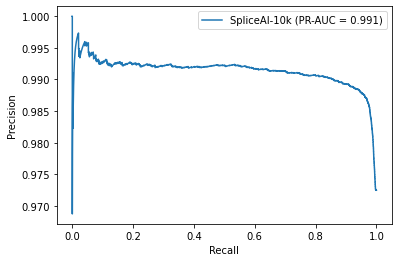

In [39]:
in_evaluation_set = clinvar['clinical_significance'].isin(['Benign','Likely_benign','Benign/Likely_benign','Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic'])
evaluation_set = clinvar[in_evaluation_set]
nulls_to_drop = ~pd.DataFrame(results).T[[4,5,6,7]][in_evaluation_set.values].isnull().any(axis=1)
evaluation_set_target =  evaluation_set['clinical_significance'].isin(['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic']).values[nulls_to_drop]
evaluation_set_results = pd.DataFrame(results).T[[4,5,6,7]][in_evaluation_set.values][nulls_to_drop].max(axis=1).values
precision1, recall1,t1 = precision_recall_curve(evaluation_set_target, evaluation_set_results)
auc_1 = average_precision_score(evaluation_set_target, evaluation_set_results)

#aucs_1.append(auc_1)
plt.plot(recall1, precision1, label=f"SpliceAI-10k (PR-AUC = {auc_1 :.3f})")
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.legend()
#plt.savefig('../Results/transformer_delta_clinvar_splice_variant_pr-auc.png',dpi=300,bbox_inches='tight')
plt.show()